# Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
%matplotlib inline

# 1. Analysis objective
The objective of the analysis is both to build a prediction model of whether a subject has heart disease based on various risk factors, and also to understand which of these risk factors are most important in determining whether someone has heart disease or not

Recall and Precision will be the main metrics that we will be measuring our model performance against. I.e. the ability to detect all positive instances, and out of all positive predictions, how many did we get correct. The f1 score is the harmonic mean of recall and precision.

# 2. Description of the data

Import the data

In [41]:
df = pd.read_csv(r'data\heart_2020_cleaned.csv')

The dataset is from a 2020 annual CDC survey data of 400,000 adults related to their health status. It is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents. 

Further details can be found here:
https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

The collator of the dataset has already performed some cleaning and removal of features. 

* The data contain 319795 observations, which each observation representing a patient.
* For each patient there are 18 features, where one of these features is the predictor feature which is a boolean describing whether the person has heart disease or not.
* Observations with missing data have already been removed from the dataset

The following feature is chosen as the response variable:
* **HeartDisease**: Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) (**boolean**)

The following features are to be used as predictor variable:
* **BMI**: Body Mass Index (**Continuous**)
* **Smoking**: Have you smoked at least 100 cigarettes in your entire life? (Note: 5 packs = 100 cigarettes) (**boolean**)
* **AlcoholDrinking**: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week (**boolean**)
* **Stroke**: Ever had a stroke? (**boolean**)
* **PhysicalHealth**: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days) (**Interval**)
* **MentalHealth**: Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days) (**Interval**)
* **DiffWalking**: Do you have serious difficulty walking or climbing stairs? (**boolean**)
* **Sex**: Are you male or female? (**Nominal**)
* **AgeCategory**: Fourteen-level age category (**Interval**)
* **Race**: Imputed race/ethnicity value (**Nominal**)
* **Diabetic**: (Ever told) (you had) diabetes? (**Boolean**)
* **PhysicalActivity**: Adults who reported doing physical activity or exercise during the past 30 days other than their regular job (**Boolean**)
* **GenHealth**: Would you say that in general your health is... (**Ordinal**)
* **SleepTime**: On average, how many hours of sleep do you get in a 24-hour period? (**Interval**)
* **Asthma**: (Ever told) (you had) asthma? (**boolean**)
* **KidneyDisease**: Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease? (**Boolean**)
* **SkinCancer**: (Ever told) (you had) skin cancer? (**Boolean**)




## 3. Data exploration, cleaning and feature engineering¶

Summary statistics for continuous variables:

In [42]:
df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
BMI             319795.0  28.33  6.36  12.02  24.03  27.34  31.42  94.85
PhysicalHealth  319795.0   3.37  7.95   0.00   0.00   0.00   2.00  30.00
MentalHealth    319795.0   3.90  7.96   0.00   0.00   0.00   3.00  30.00
SleepTime       319795.0   7.10  1.44   1.00   6.00   7.00   8.00  24.00

Countplot for the target variable

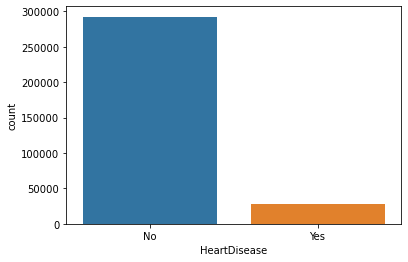

In [43]:
sns.countplot(df['HeartDisease']);

Countplot for categorical variables

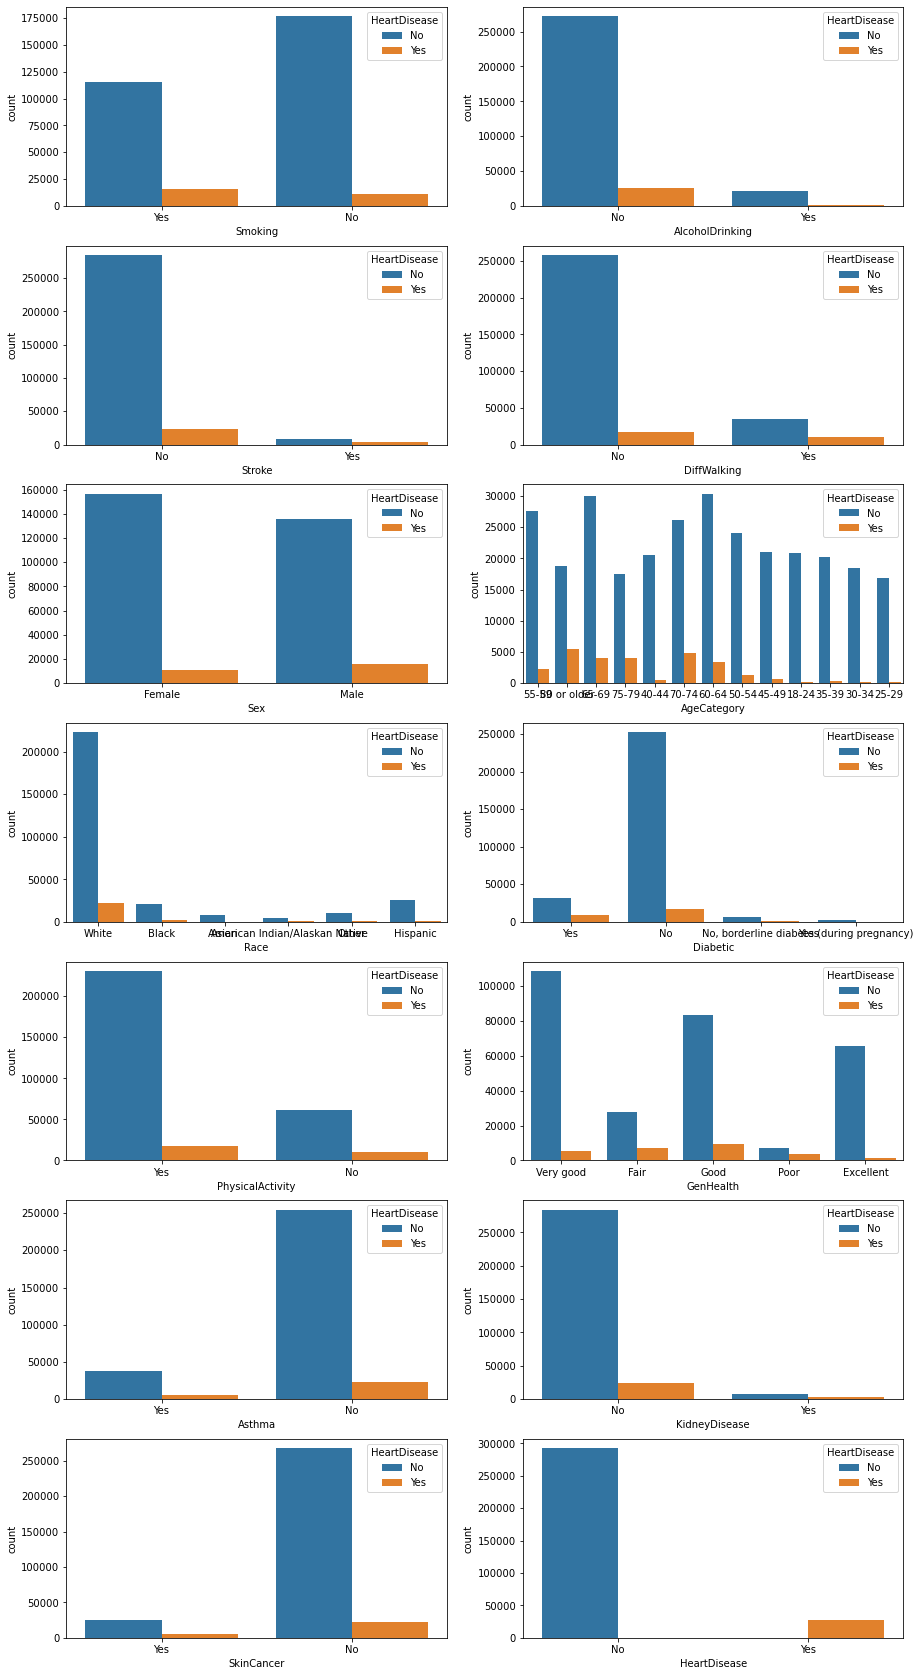

In [47]:
# categorical columns
cat_cols = df.loc[:,df.dtypes == object].columns

# plot countplots for each categorical variable
fig, ax = plt.subplots(7, 2, figsize=(15,30))

for idx, col in enumerate(cat_cols):
    sns.countplot(df[col], ax=ax[(idx-1)//2, (idx-1)%2], hue=df['HeartDisease'])

#### Missing values
There are no missing values in the data so no imputation is required

#### Categorical data
Ordinal encode the 'AgeCategory' and 'GenHealth' columns

In [7]:
ordinal_cols = ['AgeCategory', 'GenHealth']

enc_age = OrdinalEncoder(categories=[['80 or older', '75-79', '70-74', '65-69', 
                                  '60-64', '55-59', '50-54', '45-49', '40-44',
                                  '35-39', '30-34', '25-29', '18-24']])

df['AgeCategory'] = enc_age.fit_transform(df[['AgeCategory']]).astype(int)  

enc_health = OrdinalEncoder(categories=[['Excellent', 'Very good', 'Good', 'Fair', 'Poor']])

df['GenHealth'] = enc_health.fit_transform(df[['GenHealth']]).astype(int)                                

One-hot-encode categorical data:

In [8]:
# drop ordinal columns
cat_cols = cat_cols.drop(ordinal_cols)

# one-hot-encode categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#### Train test split
* Separate into X and y variables
* As the classes are unbalanced use a stratified train test split

In [9]:
X = df.drop(columns='HeartDisease_Yes')
y = df['HeartDisease_Yes']

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=5, 
                                          test_size=0.3)

train_idx, test_idx = next(strat_shuf_split.split(X, y))

X_train = X.loc[train_idx,:]
X_test = X.loc[test_idx,:]
y_train = y[train_idx]
y_test = y[test_idx]

#### Scaling
Scale the data for use in regularised logistic regression model

In [10]:
s = StandardScaler()

X_train_scaled = s.fit_transform(X_train)
X_test_scaled = s.transform(X_test)

#### Unbalanced classes

In [11]:
y_test.value_counts()

0    87727
1     8212
Name: HeartDisease_Yes, dtype: int64

The response variable is a highly unbalanced class, so this will need to be taken into account using resampling

## 4. Classifier models
### 4.1 Logistic regression
Train a Logistic Regression model using cross validation
* Use the class_weight parameter to resample the data and optimise the hyperparameter using grid search

In [12]:
lr = LogisticRegression(penalty='elasticnet', max_iter=500, solver='saga')
s = StandardScaler()

estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

x = weights = np.linspace(0.05, 0.5, 10)

params = {'regression__class_weight': [{0: x, 1: 1.0-x} for x in weights],
         'regression__l1_ratio': np.linspace(0, 1, 5),
         'regression__C': np.geomspace(0.001, 100, 6)}

grid_lr = GridSearchCV(estimator, params, cv=5, n_jobs=7, scoring='f1')
                    
grid_lr.fit(X_train, y_train);

Classification report for the Logistic regression model

In [14]:
y_pred_lr = grid_lr.predict(X_test_scaled)
print(classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     82034
           1       0.49      0.29      0.36     13905

    accuracy                           0.85     95939
   macro avg       0.69      0.62      0.64     95939
weighted avg       0.83      0.85      0.84     95939



Confusion matrix for the Logistic regression model

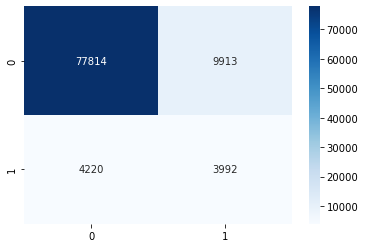

In [17]:
cm = confusion_matrix(y_test, y_pred_lr)
cmap = sns.color_palette("Blues", as_cmap=True)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)

Plot the coefficients for each feature. This gives an indication on which features are most important for predicting the response variable.

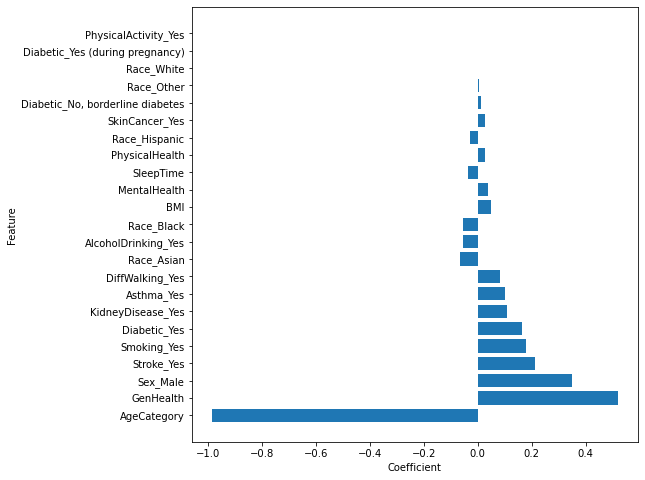

In [21]:
coefs = grid_lr.best_estimator_.named_steps["regression"].coef_[0]

df_coefs = (pd.DataFrame({'features': X_train.columns, 'coef': coefs})
            .sort_values('coef', ascending=False, key=lambda col: abs(col)))

plt.figure(figsize=(8,8));
(plt.barh(list(np.linspace(0, len(df_coefs), len(df_coefs))), 
         df_coefs['coef'], 
         tick_label=df_coefs['features']));
plt.xlabel('Coefficient');
plt.ylabel('Feature');

### 4.2 Random Forest
Train a Random Forest model using cross validation
* Use the class_weight parameter to resample the data and optimise the hyperparameter using grid search

In [ ]:
rf = RandomForestClassifier()

x = weights = np.linspace(0.05, 0.4, 8)

params = {'class_weight': [{0: x, 1: 1.0-x} for x in weights],
         'max_depth': [3, 4, 5, None],
         'n_estimators': [100, 200],
         'max_features': [3, 4, 5, 6]}

grid_rf = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=7, scoring='f1')
                    
grid_rf.fit(X_train, y_train)

Classification report for the Logistic regression model

In [25]:
y_pred_rf = grid_rf.predict(X_test)
print(classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     80033
           1       0.57      0.29      0.39     15906

    accuracy                           0.85     95939
   macro avg       0.72      0.62      0.65     95939
weighted avg       0.82      0.85      0.82     95939



Confusion matrix for the Logistic regression model

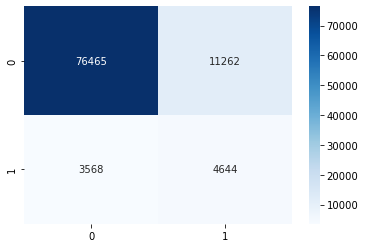

In [26]:
cm = confusion_matrix(y_test, y_pred_rf)
cmap = sns.color_palette("Blues", as_cmap=True)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)

Plot the feature importance for each feature.

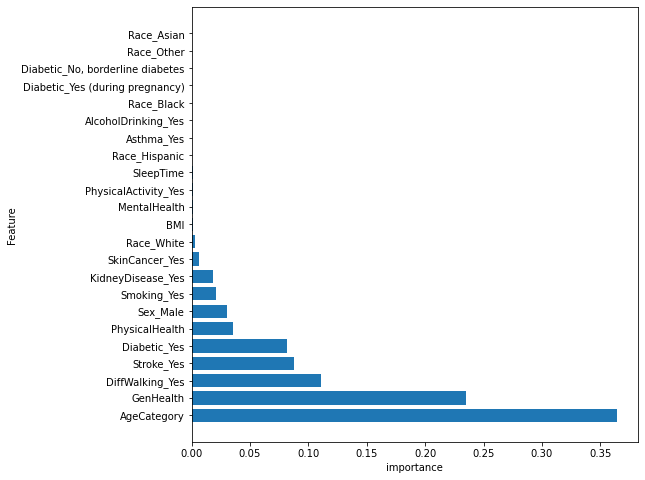

In [27]:
coefs = grid_rf.best_estimator_.feature_importances_

df_coefs_rf = (pd.DataFrame({'features': X_train.columns, 'coef': coefs})
              .sort_values('coef', ascending=False, key=lambda col: abs(col)))

plt.figure(figsize=(8,8));
(plt.barh(list(np.linspace(0, len(df_coefs_rf), len(df_coefs_rf))), 
         df_coefs_rf['coef'], 
         tick_label=df_coefs_rf['features']));
plt.xlabel('importance');
plt.ylabel('Feature');

### 4.3 XGBoost
Train a Random Forest model using cross validation

Use the scale_pos_weight parameter to resample the data and optimise the hyperparameter using grid search

In [29]:
### The parameters to be fit
params = {'scale_pos_weight': [2, 5, 10],
         'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
         'max_depth': [3, 4, 5, 6],
         'n_estimators': [100, 200],
         'subsample': [0.5, 1]}

# The grid search object
grid_xgb = GridSearchCV(XGBClassifier(), 
                      param_grid=params, 
                      scoring='f1',
                      n_jobs=7)

# Do the grid search
grid_xgb = grid_xgb.fit(X_train, y_train)

[21:38:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Classification report for the XGBoost model

In [31]:
y_pred_xgb = grid_xgb.predict(X_test)
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     79494
           1       0.59      0.30      0.39     16445

    accuracy                           0.84     95939
   macro avg       0.73      0.63      0.65     95939
weighted avg       0.82      0.84      0.82     95939



Confusion matrix for the XGBoost model

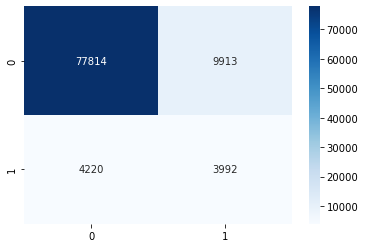

In [32]:
cm = confusion_matrix(y_test, y_pred_lr)
cmap = sns.color_palette("Blues", as_cmap=True)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)

Plot the feature importance for each feature.

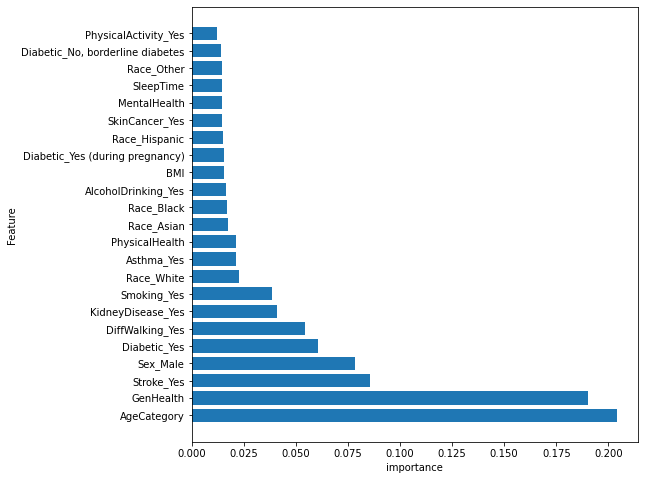

In [34]:
coefs = grid_xgb.best_estimator_.feature_importances_

df_coefs_xgb = (pd.DataFrame({'features': X_train.columns, 'coef': coefs})
              .sort_values('coef', ascending=False, key=lambda col: abs(col)))

plt.figure(figsize=(8,8));
(plt.barh(list(np.linspace(0, len(df_coefs_xgb), len(df_coefs_xgb))), 
         df_coefs_xgb['coef'], 
         tick_label=df_coefs_xgb['features']));
plt.xlabel('importance');
plt.ylabel('Feature');

# 5. Model choice / Findings and insights

The Random Forest and XGBoost models both have the same f1 score of 0.39, which is better than that for the Logistic regression model.

Recall and precision are both slightly higher for the XGBoost model, so this model is deemed the best according to the criteria of recall, precision and f1 score.

All of the metrics for the positive class were much lower than that achieved for the negative class.

The other modelling objective was to was to investigate feature importances, and in this regard all three models have 'AgeCategory' and 'GenHealth' as the top 2 features in terms of importance, so these are the best predictors of Heart disease. Other importanct predictors include 'Sex' and 'Stroke' which refers to whether the patient has a stroke before.



# 6. Next steps
Feature engineering, such as adding polynomial features for the most predictive features may improve prediction accuracy

Also, a stacking classifier could be used to combine the separate classifier models into a possibly better predictor.